# Data Cleaning

## Import Libraries

In [1]:
# Essentails 
import numpy as np
import pandas as pd

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')

# Hide warnings
import warnings
warnings.filterwarnings('ignore')

# Miscellaneous
import re

# Data processing
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder

## Read in the Data

In [2]:
# Load the training dataset
train = pd.read_csv('train.csv')

# Load the testing dataset
test = pd.read_csv('test.csv')

## Combine Data

Combining the training and the testing dataset to make the cleaning process easier

In [3]:
# Combine the two datasets using pd.concat
combined = pd.concat((train, test), axis=0, ignore_index=True)

In [4]:
print('Shape of training data:', train.shape)

Shape of training data: (891, 12)


In [5]:
print('Shape of testing data:', test.shape)

Shape of testing data: (418, 11)


In [6]:
print('Shape of combined data:', combined.shape)

Shape of combined data: (1309, 12)


In [7]:
# Drop passengerId as it does not contain any useful information
train.drop('PassengerId', axis=1, inplace=True)
combined.drop('PassengerId', axis=1, inplace=True)

## Name Feature
The name column is subdivided into 3: <br>
* Title
* First name 
* Last name
    
We can use regular expressions to extract the title from the name column of each person

In [9]:
def extract_title(dataframe):
    """
    Takes the dataframe as input and extracts the title from the name of each person.
    """
    
    titles = list() # Array to store the titles
    
    for i in dataframe.index:
        titles.append(re.findall(r',\s(.*?)\.', dataframe.loc[i, 'Name']))
        
    return titles

In [10]:
# Extracting and storing the titles in a list
train_titles = extract_title(train)
combined_titles = extract_title(combined)

In [11]:
# Converting the list to a numpy array and then appending it to the training and combined datasets 
train['Titles'] = np.array(train_titles)
combined['Titles'] = np.array(combined_titles)

In [12]:
# Drop the Name column in both datasets as it is no longer needed
train.drop('Name', axis=1, inplace=True)
combined.drop('Name', axis=1, inplace=True)

In [13]:
combined['Titles'].value_counts()

Mr              757
Miss            260
Mrs             197
Master           61
Dr                8
Rev               8
Col               4
Major             2
Ms                2
Mlle              2
Jonkheer          1
Capt              1
Don               1
the Countess      1
Lady              1
Mme               1
Sir               1
Dona              1
Name: Titles, dtype: int64

Let's replace these titles with more common ones. This will help reduce the number of features in our dataset, making our ML model faster 

In [14]:
def categorize_titles(dataset):
    """
    Takes the dataset as input and categorizes titles into 7 sub-groups: Mr, Mrs, Master, Miss, Military, Royal, and Other
    """
    
    dataset['Titles'] = dataset['Titles'].replace(['Mlle', 'Ms'], 'Miss')
    dataset['Titles'] = dataset['Titles'].replace('Mme', 'Mrs')
    dataset['Titles'] = dataset['Titles'].replace(['Don', 'Jonkheer', 'Dona', 'Dr', 'Rev'], 'Other')
    dataset['Titles'] = dataset['Titles'].replace(['Capt', 'Col', 'Major'], 'Military')
    dataset['Titles'] = dataset['Titles'].replace(['Lady', 'the Countess', 'Sir'], 'Royal')

In [15]:
# Calling the categorize_titles function on the training dataset
categorize_titles(train)

# Calling the categorize_titles function on the combined dataset
categorize_titles(combined)

In [16]:
combined['Titles'].value_counts()

Mr          757
Miss        264
Mrs         198
Master       61
Other        19
Military      7
Royal         3
Name: Titles, dtype: int64

Percentage of Title = Royal who survived: 100.0 %
Percentage of Title = Mrs who survived: 79.37 %
Percentage of Title = Miss who survived: 70.27 %
Percentage of Title = Master who survived: 57.5 %
Percentage of Title = Military who survived: 40.0 %
Percentage of Title = Mr who survived: 15.67 %


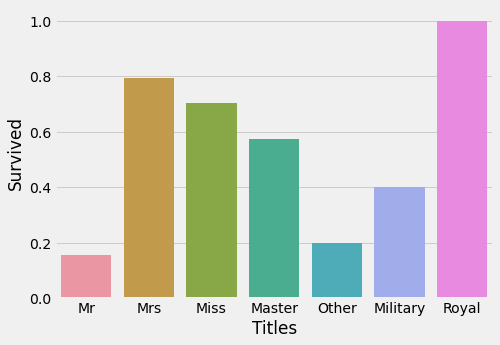

In [17]:
print('Percentage of Title = Royal who survived:', round(train.groupby('Titles')['Survived'].value_counts(normalize=True)['Royal'][1] * 100, 2), '%')
print('Percentage of Title = Mrs who survived:', round(train.groupby('Titles')['Survived'].value_counts(normalize=True)['Mrs'][1] * 100, 2), '%')
print('Percentage of Title = Miss who survived:', round(train.groupby('Titles')['Survived'].value_counts(normalize=True)['Miss'][1] * 100, 2), '%')
print('Percentage of Title = Master who survived:', round(train.groupby('Titles')['Survived'].value_counts(normalize=True)['Master'][1] * 100, 2), '%')
print('Percentage of Title = Military who survived:', round(train.groupby('Titles')['Survived'].value_counts(normalize=True)['Military'][1] * 100, 2), '%')
print('Percentage of Title = Mr who survived:', round(train.groupby('Titles')['Survived'].value_counts(normalize=True)['Mr'][1] * 100, 2), '%')


# Resize the plot
plt.figure(figsize=(7, 5))

# Plot a barplot for Titles vs Survived
sns.barplot(x=train['Titles'], y=train['Survived'], errwidth=0)
plt.show()

## Fix Missing Values in the Age Feature

In [18]:
# Create a new dataframe by merging the age column and the title column
missing_age = pd.concat((combined['Age'], combined['Titles']), axis=1, ignore_index=True)
missing_age.columns = ['Age', 'Titles']

In [19]:
# Median age grouped by title
median_age_grp = train.groupby('Titles')['Age'].median()

In [20]:
median_age_grp

Titles
Master       3.5
Military    56.0
Miss        21.0
Mr          30.0
Mrs         35.0
Other       43.0
Royal       48.0
Name: Age, dtype: float64

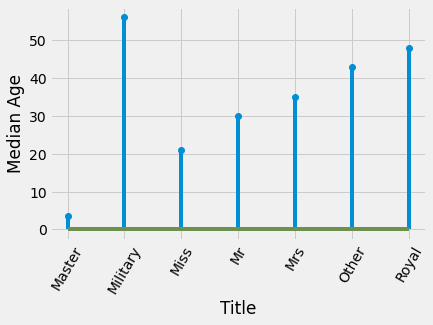

In [21]:
# Stem-plot to plot median age for all titles
plt.stem(median_age_grp)

# Renaming labels of the X-axis 
plt.xticks(ticks=[0, 1, 2, 3, 4, 5, 6], labels=median_age_grp.index, rotation=60)

# Rename X and Y axis
plt.xlabel('Title')
plt.ylabel('Median Age')
plt.show()

In [22]:
def impute_age(dataset):
    """
    Takes the dataset as input and fills in the missing values for the age column.
    
    """
    
    for i in range(dataset.shape[0]):
        if np.isnan(dataset.loc[i, 'Age']):
            dataset.loc[i, 'Age'] = median_age_grp[dataset.loc[i, 'Titles']]

In [23]:
# Fill in the missing values for the age column
impute_age(train)
impute_age(combined)

In [24]:
# Check for missing values
combined.isnull().sum()

Survived     418
Pclass         0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           1
Cabin       1014
Embarked       2
Titles         0
dtype: int64

Hurray! No more missing data points in the Age column!

Let's move on to the next feature

## Cabin Feature

The Cabin feature has 1000 (77.4 %) missing values. Since so much of the feature is missing, it would be hard to fill in the missing values.

What we could do instead is create a new binary variable that stores information regarding the cabin.
* Recorded cabin number = True
* No recorded cabin number = False

In [25]:
# RecordedCabinNumber = 1 if the corresponding Cabin value is not missing, otherwise RecordedCabinNumber = 0
train['RecordedCabinNumber'] = (train['Cabin'].notnull().astype(int))
combined['RecordedCabinNumber'] = (combined['Cabin'].notnull().astype(int))

In [26]:
combined.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Titles,RecordedCabinNumber
0,0.0,3,male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr,0
1,1.0,1,female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs,1
2,1.0,3,female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss,0
3,1.0,1,female,35.0,1,0,113803,53.1000,C123,S,Mrs,1
4,0.0,3,male,35.0,0,0,373450,8.0500,NaN,S,Mr,0


Percentage of people with a recorded cabin number who survived: 66.67 %
Percentage of people without a recorded cabin number who survived: 29.99 %


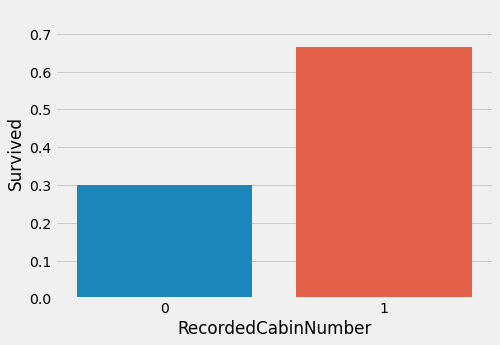

In [27]:
print('Percentage of people with a recorded cabin number who survived:', round(train.groupby('RecordedCabinNumber')['Survived'].value_counts(normalize=True)[1][1] * 100, 2), '%')
print('Percentage of people without a recorded cabin number who survived:', round(train.groupby('RecordedCabinNumber')['Survived'].value_counts(normalize=True)[0][1] * 100, 2), '%')

# Resize the plot
plt.figure(figsize=(7, 5))

# Plot a barplot for Titles vs Survived
sns.barplot(x=train['RecordedCabinNumber'], y=train['Survived'], errwidth=0)
plt.show()

In [28]:
# Drop the Cabin column from both datasets as it is no longer necessary
train.drop('Cabin', axis=1, inplace=True)
combined.drop('Cabin', axis=1, inplace=True)

## Embarked Feature
Since the Embarked feature has only 2 missing values in the training dataset, we can simply remove those observations from the training and the combined datasets. 

In [29]:
missing_embarked = train['Embarked'].isnull().loc[lambda x: x==True].index

In [30]:
train.drop(missing_embarked, axis=0, inplace=True)
combined.drop(missing_embarked, axis=0, inplace=True)

## Fare Feature

In [31]:
# Locate index of rows in the Fare column that have the value of NA 
combined['Fare'].isnull().loc[lambda x: x==True].index

Int64Index([1043], dtype='int64')

In [32]:
# Display the row with the missing data point
combined.iloc[1043]

Survived                   NaN
Pclass                       3
Sex                       male
Age                         13
SibSp                        4
Parch                        2
Ticket                  347077
Fare                   31.3875
Embarked                     S
Titles                  Master
RecordedCabinNumber          0
Name: 1045, dtype: object

In [33]:
# Impute the missing value based on the median passenger fare for that port of embarkation.
combined['Fare'].fillna(train.groupby('Embarked')['Fare'].median()['S'], inplace=True)

In [34]:
# Display the row again
combined.loc[1043]

Survived                NaN
Pclass                    3
Sex                    male
Age                    60.5
SibSp                     0
Parch                     0
Ticket                 3701
Fare                     13
Embarked                  S
Titles                   Mr
RecordedCabinNumber       0
Name: 1043, dtype: object

In [35]:
# Check for missing values
combined.isnull().sum()

Survived               418
Pclass                   0
Sex                      0
Age                      0
SibSp                    0
Parch                    0
Ticket                   0
Fare                     0
Embarked                 0
Titles                   0
RecordedCabinNumber      0
dtype: int64

No more missing values in our dataset!

In [36]:
# Drop the ticket column from both datasets since it does not yield any useful information
train.drop('Ticket', axis=1, inplace=True)
combined.drop('Ticket', axis=1, inplace=True)

## SibSp and Parch

In [37]:
def is_alone(dataset):
    """
    If the passenger is traveling alone: isAlone = 1
    If the passenger is not traveling alone: isAlone = 0
    """
    for i in dataset.index:
        if dataset.loc[i, 'SibSp'] == 0 and dataset.loc[i, 'Parch'] == 0:
            dataset.loc[i, 'isAlone'] = 1
        else:
            dataset.loc[i, 'isAlone'] = 0

In [38]:
is_alone(train)
is_alone(combined)

Percentage of isAlone = True who survived: 30.09 %
Percentage of isAlone = False who survived: 50.56 %


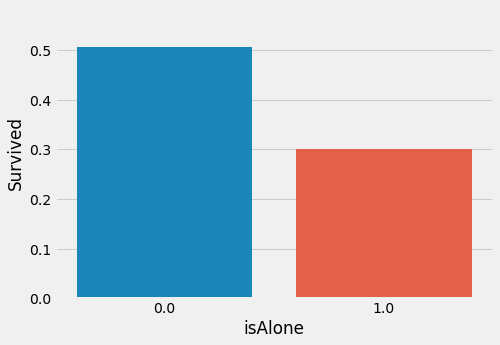

In [39]:
print('Percentage of isAlone = True who survived:', round(train.groupby('isAlone')['Survived'].value_counts(normalize=True)[1][1] * 100, 2), '%')
print('Percentage of isAlone = False who survived:', round(train.groupby('isAlone')['Survived'].value_counts(normalize=True)[0][1] * 100, 2), '%')

# Resize the plot
plt.figure(figsize=(7, 5))

# Plot a barplot for isAlone vs Survived
sns.barplot(x=train['isAlone'], y=train['Survived'], errwidth=0)
plt.show()

In [40]:
# Remove SibSp and Parch from both datasets
train.drop(['SibSp', 'Parch'], axis=1, inplace=True)
combined.drop(['SibSp', 'Parch'], axis=1, inplace=True)

## Encode Categorical Features

In [41]:
# Select categorical features with more than 3 unique values
categorical_features = pd.concat((combined['Embarked'], combined['Titles']), axis=1) 

In [42]:
# One-hot encode all categorical features with more than 3 unique values
encoded_features = pd.get_dummies(categorical_features)

In [43]:
# Preview one-hot encoded features
encoded_features.head()

,Embarked_C,Embarked_Q,Embarked_S,Titles_Master,Titles_Military,Titles_Miss,Titles_Mr,Titles_Mrs,Titles_Other,Titles_Royal
0,0,0,1,0,0,0,1,0,0,0
1,1,0,0,0,0,0,0,1,0,0
2,0,0,1,0,0,1,0,0,0,0
3,0,0,1,0,0,0,0,1,0,0
4,0,0,1,0,0,0,1,0,0,0


In [44]:
# Converting the Sex column to 1s and 0s
le = LabelEncoder()
le.fit(train['Sex'].values)

# Replacing the Sex column with numerical values 
train['Sex'] = le.transform(train['Sex'].values)
combined['Sex'] = le.transform(combined['Sex'].values)

In [45]:
# Delete the Embarked and the Titles column as it is no longer needed
combined.drop(['Embarked', 'Titles'], axis=1, inplace=True)

In [46]:
# Append the encoded features to the combined dataset
combined = pd.concat((combined, encoded_features), axis=1)

## Scaling and Transforming Continuous Features

In [47]:
# Coverting the age column in the training and combined dataset to a numpy array
age_train = train['Age'].values.reshape(-1, 1)
age_combined = combined['Age'].values.reshape(-1, 1)

# Coverting the fare column in the combined dataset to a numpy array
fare = combined['Fare'].values

In [48]:
print(max(age_train))
print(min(age_train))

[80.]
[0.42]


In [49]:
# Instantiate MinMaxScaler object
scaler_age = MinMaxScaler()

# Fit the scaler only on the training data to avoid data leakage
scaler_age.fit(age_train)

# Apply the transform on the combined dataset 
age_combined = scaler_age.transform(age_combined)

In [50]:
ft = FunctionTransformer(lambda x: np.log10(x+1))
fare = ft.transform(fare)

In [51]:
train['Age'] = age_train
combined['Age'] = age_combined
combined['Fare'] = fare

In [52]:
# Ov
combined.head(10)

,Survived,Pclass,Sex,Age,Fare,RecordedCabinNumber,isAlone,Embarked_C,Embarked_Q,Embarked_S,Titles_Master,Titles_Military,Titles_Miss,Titles_Mr,Titles_Mrs,Titles_Other,Titles_Royal
0,0.0,3,1,0.271174,0.916454,0,0.0,0,0,1,0,0,0,1,0,0,0
1,1.0,1,0,0.472229,1.859038,1,0.0,1,0,0,0,0,0,0,1,0,0
2,1.0,3,0,0.321438,0.950608,0,1.0,0,0,1,0,0,1,0,0,0,0
3,1.0,1,0,0.434531,1.733197,1,0.0,0,0,1,0,0,0,0,1,0,0
4,0.0,3,1,0.434531,0.956649,0,1.0,0,0,1,0,0,0,1,0,0,0
5,0.0,3,1,0.371701,0.975813,0,1.0,0,1,0,0,0,0,1,0,0,0
6,0.0,1,1,0.673285,1.723148,1,1.0,0,0,1,0,0,0,1,0,0,0
7,0.0,3,1,0.019854,1.343901,0,0.0,0,0,1,1,0,0,0,0,0,0
8,1.0,3,0,0.334004,1.083979,0,0.0,0,0,1,0,0,0,0,1,0,0
9,1.0,2,0,0.170646,1.492352,0,0.0,1,0,0,0,0,0,0,1,0,0


In [53]:
train_cleaned = combined.loc[:890, :]
testing_cleaned = combined.loc[891:, :]

In [54]:
testing_cleaned.drop('Survived', axis=1, inplace=True)

In [55]:
train_cleaned.to_csv('train_cleaned.csv', index=False)

In [56]:
testing_cleaned.to_csv('testing_cleaned.csv', index=False)

## Final Step - Model Building